### Environment Info
- Python: 3.10
- Environment: `toponomastica-stenico` (created from `environment.yml`)

In [28]:
import pandas as pd

from collections import Counter
import string 

import os
from pathlib import Path

import matplotlib.pyplot as plt

import numpy as np
np.random.seed(42)

In [29]:
comune = "Stenico"
data_path = Path("../data/raw/") / f"{comune}.json"
data = pd.read_json(data_path)

data['quota'] = data['quota'].astype('Int64')

data[['lon', 'lat']] = pd.DataFrame(data['lat_long'].tolist(), index=data.index)
data = data.drop(columns=["lat_long"])

### Data Analysis and Cleaning

In [30]:
data.info()
data.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1718 entries, 0 to 1717
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               1718 non-null   int64  
 1   nome             1713 non-null   object 
 2   forma_ufficiale  213 non-null    object 
 3   comune           1718 non-null   object 
 4   ind_geografico   1718 non-null   object 
 5   descrizione      1718 non-null   object 
 6   quota            1636 non-null   Int64  
 7   varianti         414 non-null    object 
 8   lon              1718 non-null   float64
 9   lat              1718 non-null   float64
dtypes: Int64(1), float64(2), int64(1), object(6)
memory usage: 136.0+ KB


id                 nome forma_ufficiale   comune  \
1713  1713      Zapèl del Fanio            None  Stenico   
1714  1714     Zapèl del Ghirlo            None  Stenico   
1715  1715             Zendàgol            None  Stenico   
1716  1716  Zimitèri del colèra            None  Stenico   
1717  1717        Zucal dal bus            None  Stenico   

                                         ind_geografico  \
1713                 Tratto ripido della Strada de Dóa,   
1714  Tratto ripido e accidentato della Strada de la...   
1715               Vallecola coltivata a campi e prati,   
1716        Piccola radura a prato e bosco circostante,   
1717                                   Parete rocciosa,   

                                            descrizione  quota  \
1713  situato ad E di Sclemo, nei pressi del Pelaról...    680   
1714  fra i Ghirli de sóra e i Ghirli de sóta, espos...   1560   
1715  in parte edificata, situata a NE di Stenico, f...    710   
1716  situati fra la Strada del Spiaz de le fontane ...    810   
1717  che presenta una grotta nella roccia, situata ...   1450   

            varianti        lon        lat  
1713  [Zapèl de Dóa]  10.893135  46.054973  
1714            None  10.843728  46.080168  
1715            None  10.861419  46.054054  
1716            None  10.874968  46.057559  
1717  [Cròz dal bus]  10.826073  46.179745

##### Fix missing `nome`

In [31]:
data.loc[data['nome'].isna(), 'nome'] = data.loc[data['nome'].isna(), 'forma_ufficiale']

##### Fix missimg `quota`. 
Downloading the missing elevations from `open-elevation.com`, may not be very accurate.

In [32]:
import requests

def get_elevation(lat, lon):
    url = "https://api.open-elevation.com/api/v1/lookup"
    params = {"locations": f"{lat},{lon}"}
    response = requests.get(url, params=params)
    if response.ok:
        return response.json()['results'][0]['elevation']
    else:
        return None

missing_quota_mask = data['quota'].isna()
for i, row in data[missing_quota_mask].iterrows():
    lat, lon = row['lat'], row['lon']
    elevation = get_elevation(lat, lon)
    data.at[i, 'quota'] = elevation

print("Downloaded quota for these entries:")
data.loc[missing_quota_mask, ['nome', 'quota']]

Downloaded quota for these entries:


nome  quota
33                          Bagnot    723
43             Baloton de Venédech   2023
77                           Brégn    529
80                           Bróge    772
84                Bróilo dei Clòci    739
...                            ...    ...
1453  Strada del pàscol dei Tavódi    649
1542               Tóf del Cartèro    675
1589                           Val    574
1631               Val dei Spiazzi    675
1698                         Viata    661

[82 rows x 2 columns]

##### Merging columns `ind_geografico` and `descrizione`. 

Old: 
<hr>

**Indicatore geografico**: *Piazzola a prato, con resti di un capanno,* 
<br>

**Descrizione**: *situata nella parte SO della Val d'Agola, poco a N del Passo Bregn da l'Ors, nei pressi della Madonina (C.C. di Giustino), dove iniziano il Sentér de la Pala ed il Sentér del Grual, a 1850 m di quota.*

<hr>

<br>New: 
<hr>

**Descrizione**: *Piazzola a prato, con resti di un capanno, situata nella parte SO della Val d'Agola, poco a N del Passo Bregn da l'Ors, nei pressi della Madonina (C.C. di Giustino), dove iniziano il Sentér de la Pala ed il Sentér del Grual, a 1850 m di quota.*

<hr>

In [33]:
data["descrizione"] = data["ind_geografico"] + " " + data["descrizione"]
data = data.drop(columns=["ind_geografico"])

##### Identify and Assign tags based on text description.

In [34]:
import spacy
import spacy.cli

try:
    nlp = spacy.load("it_core_news_lg")
except OSError:
    spacy.cli.download("it_core_news_lg")
    nlp = spacy.load("it_core_news_lg")

In [35]:
def extract_tags(text):
    if pd.isna(text):
        return []
    
    doc = nlp(text)
    
    named_ents = [ent.text for ent in doc.ents if ent.label_ in {"LOC", "FAC", "ORG"}]
    
    noun_chunks = [chunk.text for chunk in doc.noun_chunks]
    
    tags = list(set(named_ents + noun_chunks))
    
    return tags

In [36]:
tmp = data.copy()
tmp['tags'] = tmp['descrizione'].apply(extract_tags)

flattened_tags = [tag.lower() for tags in tmp['tags'] for tag in tags]

tag_counts = Counter(flattened_tags)
tag_counts_df = pd.DataFrame(tag_counts.items(), columns=["tag", "count"]).sort_values(by="count", ascending=False)
print(tag_counts_df)

                                                    tag  count
33                                                quota   1143
6                                                 monte    731
16                                                    s    652
28                                                  che    620
140                                              strada    492
...                                                 ...    ...
2953                                   e del cóel marc'      1
2954                                      acqua interno      1
2955                                           un pozzo      1
2956                                           o la val      1
5682  sponda sinistra della val d'agola, poco a mont...      1

[5683 rows x 2 columns]


In [37]:
def is_valid_tag(tag):
    if len(tag) <= 2:
        return False
    if tag in {"s", "e", "n", "so", "se", "ne"}:
        return False
    if all(c in string.punctuation + " " for c in tag):
        return False
    return True

def normalize_tag(tag):
    tag = tag.strip()
    for article in ['la ', 'il ', 'lo ', "l'", 'i', 'gli', 'le', 'un', 'uno', 'una', "un'"] + list(string.punctuation):
            if tag.startswith(article):
                tag = tag[len(article):]
    
    return tag

tag_counts_df['tag'] = tag_counts_df['tag'].apply(normalize_tag)
tag_counts_df = tag_counts_df[tag_counts_df['tag'].apply(is_valid_tag)]
tag_counts_df = tag_counts_df.groupby('tag', as_index=False)['count'].sum()

tags_to_remove = ['monte', 'versante', 'monte valandro', 'che', 'quota', 'a quota', 'val', 'c.c.', 'valle', 'parte', 'sera', 'tratto']

df_filtered = tag_counts_df[~tag_counts_df['tag'].isin(tags_to_remove)].copy()
df_filtered.sort_values(by="count", ascending=False)[:20]

tag  count
4380                               strada    707
3671                                prato    369
4988                             valandro    323
4373                              stenico    288
1304                                bosco    235
4086                               sclemo    195
1434                             campagna    191
101                               a quota    190
4897                         val d'algone    158
5160                         villa banale    155
4192                                  seo    151
1774                              costone    137
2218                                  dòs    135
4813                                  tóf    132
2432                               fianco    130
1100                               algone    126
4152                               sentér    118
3357                              pendici    116
4595                   strada provinciale    100
4608  strada provinciale n. 34 del lisano     99

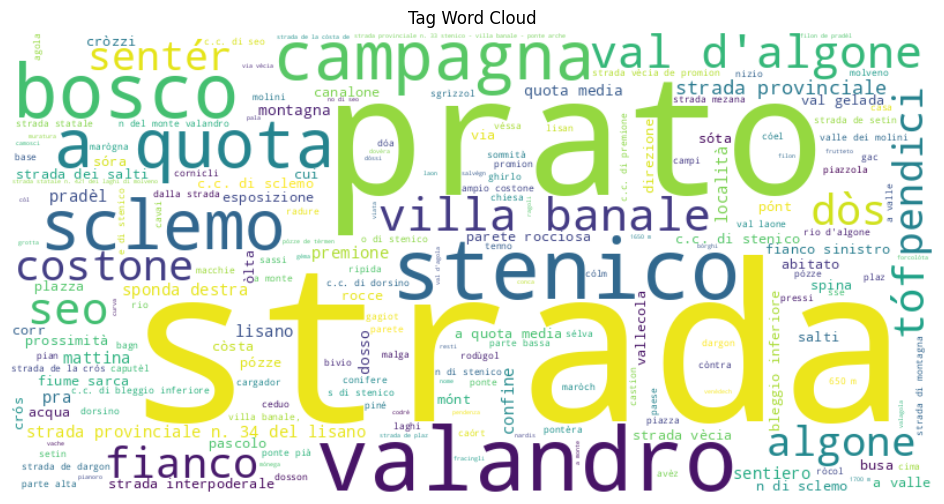

In [38]:
from wordcloud import WordCloud

tag_freq = dict(zip(df_filtered['tag'], df_filtered['count']))

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(tag_freq)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Tag Word Cloud')
plt.show()

Manually selecting the most revalent tags.

In [39]:
tags = ["stenico", "seo", "sclemo", "premione", "villa banale", "bosco", "valandro", "algone", "campagna", "prato", "strada", "sentér", "pascolo", "agola", "pónt"]

def assign_tags(text):
    if pd.isna(text):
        return []
    text_lower = text.lower()
    found = [tag for tag in tags if tag.lower() in text_lower]
    return found

data['tags'] = data['descrizione'].apply(assign_tags)

##### Cluster points into the two macro areas of Stenico and Stenico II.

In [40]:
from sklearn.cluster import DBSCAN

coords_rad = np.radians(data[['lat', 'lon']].to_numpy())

# DBSCAN with haversine distance (eps in radians = km / Earth's radius)
kms_per_radian = 6371.0088
epsilon = 1.0 / kms_per_radian  # 1 km

cluster_names = {
    0: "Stenico",
    1: "Valagola (Stenico II)",
}

db = DBSCAN(eps=epsilon, min_samples=2, metric='haversine').fit(coords_rad)

numeric_labels = db.labels_
named_labels = [cluster_names.get(label, "Unknown") for label in numeric_labels]

data['cluster'] = named_labels

##### Visualize clusters on map

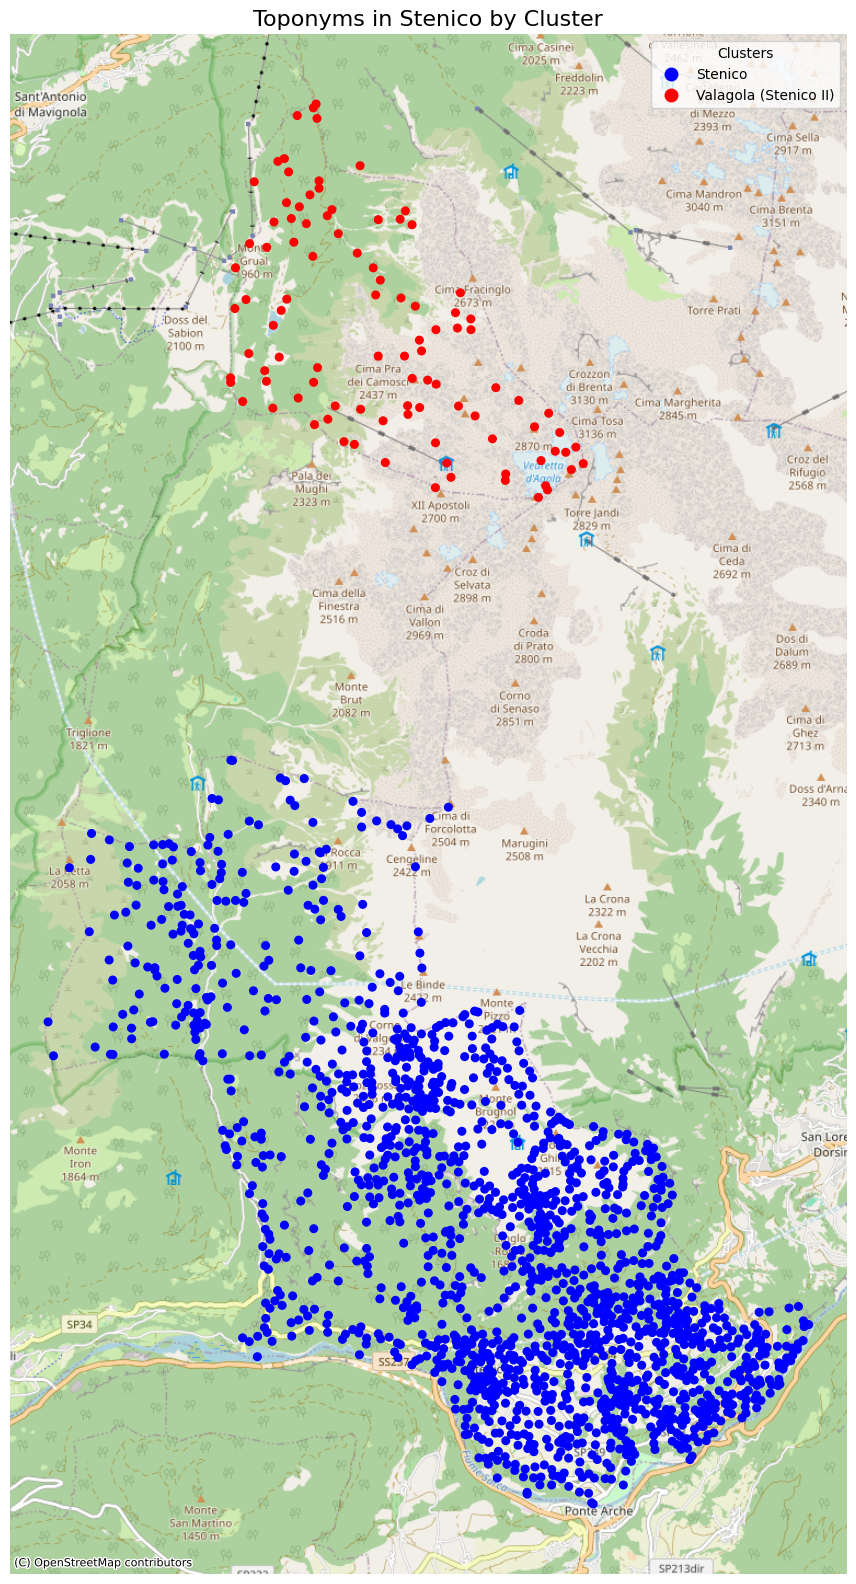

In [41]:
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx

def get_GeoDataFrame(data):
    geometry = [Point(xy) for xy in zip(data['lon'], data['lat'])]
    gdf = gpd.GeoDataFrame(data, geometry=geometry, crs="EPSG:4326")

    gdf = gdf.to_crs(epsg=3857)
    return gdf


gdf = get_GeoDataFrame(data)
fig, ax = plt.subplots(figsize=(20, 20))
gdf.plot(
    ax=ax,
    column='cluster',
    categorical=True,
    legend=True,
    legend_kwds={'title': "Clusters"},
    markersize=30,
    cmap='bwr'
)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_title("Toponyms in Stenico by Cluster", fontsize=16)
ax.set_axis_off()

plt.show()


##### Hierarchical clustering
Trying to assign each point to a specific area.

In [50]:
from math import radians, sin, cos, sqrt, atan2
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage

coords = data[['lat', 'lon', 'quota']].to_numpy()

def geo3d_distance(p1, p2, alt_scale=1/800):  # alt_scale = 1 unit = 100m
    R = 6371.0088
    lat1, lon1, z1 = p1
    lat2, lon2, z2 = p2

    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)

    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    d_geo = R * c

    d_alt = alt_scale * abs(z2 - z1)

    return sqrt(d_geo**2 + d_alt**2)

# Compute distance matrix
n = len(coords)
D_geo = np.zeros((n, n))
for i in range(n):
    for j in range(i + 1, n):
        d = geo3d_distance(coords[i], coords[j])
        D_geo[i, j] = D_geo[j, i] = d

# Text distance
italian_stopwords = nlp.Defaults.stop_words
tfidf = TfidfVectorizer(max_features=70, stop_words=list(italian_stopwords))
desc_tfidf = tfidf.fit_transform(data['descrizione'].fillna("")).toarray()
desc_tfidf_norm = normalize(desc_tfidf)

D_text = pairwise_distances(desc_tfidf_norm, metric='cosine')

GEO_WEIGHT = 1.
TEXT_WEIGHT = 2.7
D_combined = GEO_WEIGHT * D_geo + TEXT_WEIGHT * D_text

D_condensed = squareform(D_combined)

Z = linkage(D_condensed, method='complete')

/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gl', 'nient'] not in stop_words.
  warnings.warn(


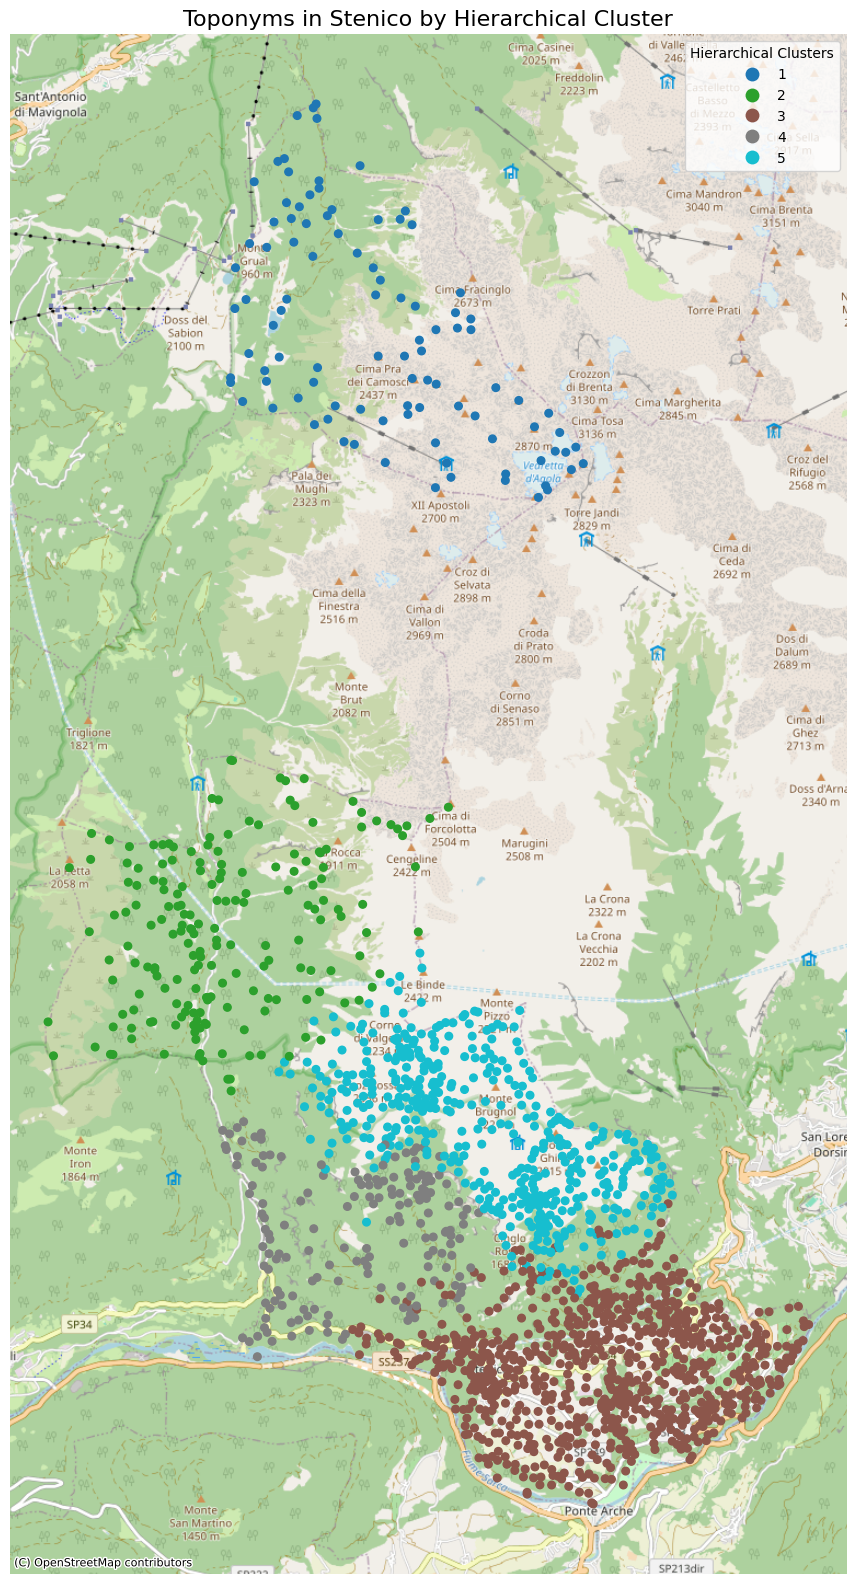

In [51]:
from scipy.cluster.hierarchy import fcluster
import contextily as ctx

num_clusters = 5
data['hc_cluster'] = fcluster(Z, t=num_clusters, criterion='maxclust')

gdf = get_GeoDataFrame(data)
fig, ax = plt.subplots(figsize=(20, 20))
gdf.plot(
    ax=ax,
    column='hc_cluster',
    categorical=True,
    legend=True,
    legend_kwds={'title': "Hierarchical Clusters"},
    markersize=30,
    cmap='tab10'
)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_title("Toponyms in Stenico by Hierarchical Cluster", fontsize=16)
ax.set_axis_off()

plt.show()

Give each cluster it's name and save the plot. 

/tmp/ipykernel_494/3106057256.py:28: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  lambda g: g.unary_union.centroid


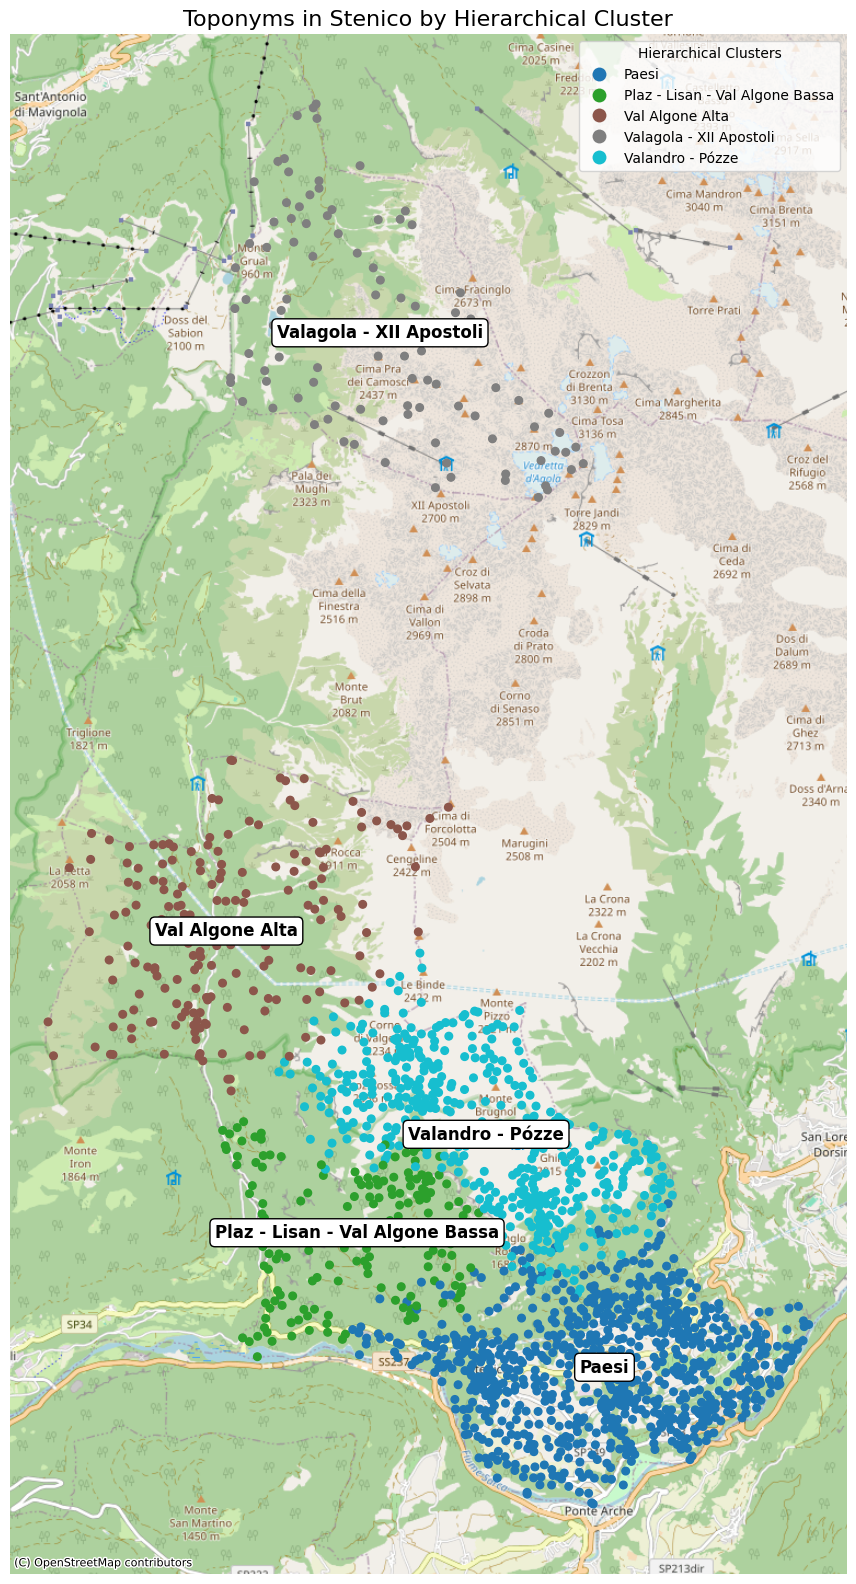

In [52]:
cluster_names = {
    1: "Valagola - XII Apostoli",
    2: "Val Algone Alta",
    3: "Paesi",
    4: "Plaz - Lisan - Val Algone Bassa",
    5: "Valandro - Pózze",
}
data['hc_cluster'] = data['hc_cluster'].map(cluster_names)

cluster_maps_path = Path("../data/cluster_maps/")
os.makedirs(cluster_maps_path, exist_ok=True)

gdf = get_GeoDataFrame(data)
fig, ax = plt.subplots(figsize=(20, 20))
gdf.plot(
    ax=ax,
    column='hc_cluster',
    categorical=True,
    legend=True,
    legend_kwds={'title': "Hierarchical Clusters"},
    markersize=30,
    cmap='tab10'
)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

cluster_centroids = gdf.groupby('hc_cluster')[['geometry']].apply(
    lambda g: g.unary_union.centroid
)

for cluster_id, centroid in cluster_centroids.items():
    ax.text(
        centroid.x, centroid.y,
        str(cluster_id),
        fontsize=12, fontweight='bold',
        color='black', ha='center', va='center',
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1)
    )

ax.set_title("Toponyms in Stenico by Hierarchical Cluster", fontsize=16)
ax.set_axis_off()

plt.savefig(cluster_maps_path / "Hierarchical_Cluster_Map.png", dpi=200, bbox_inches='tight', pad_inches=0.1)

Plot and save each cluster individually.

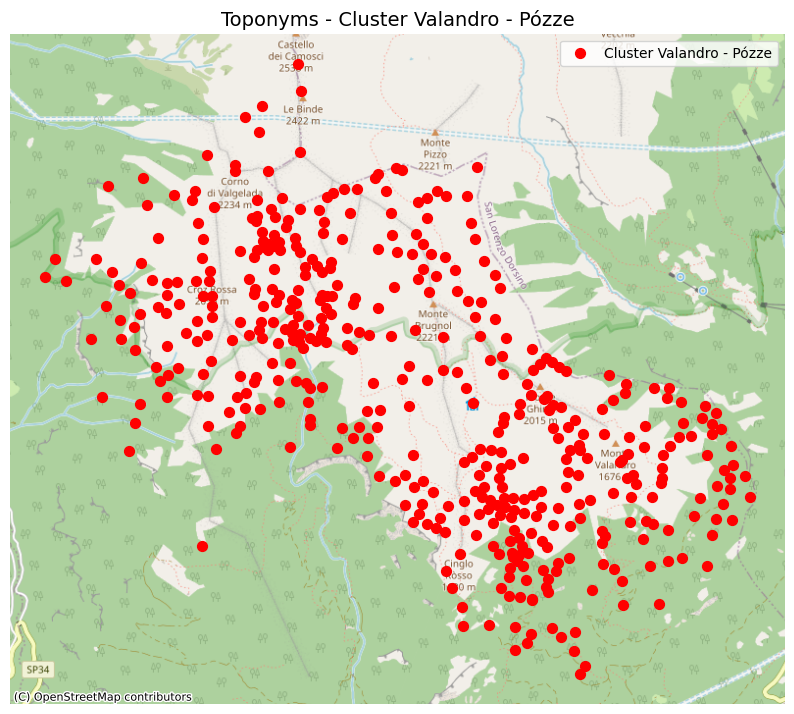

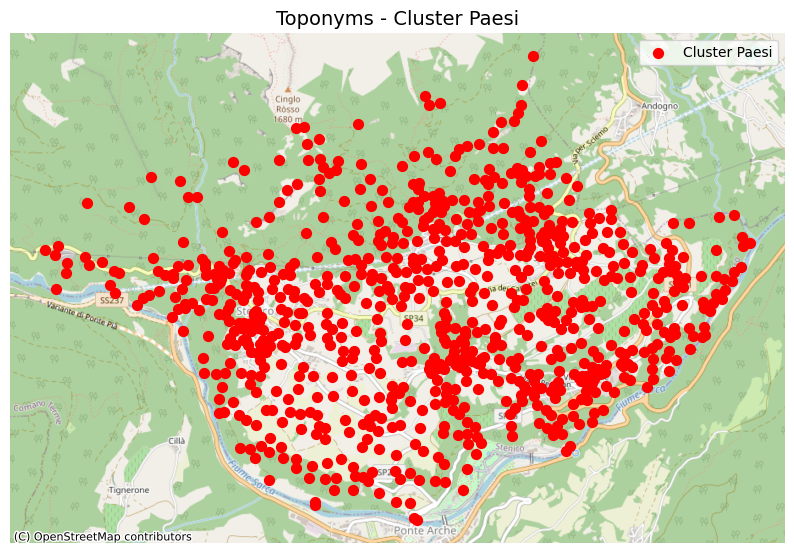

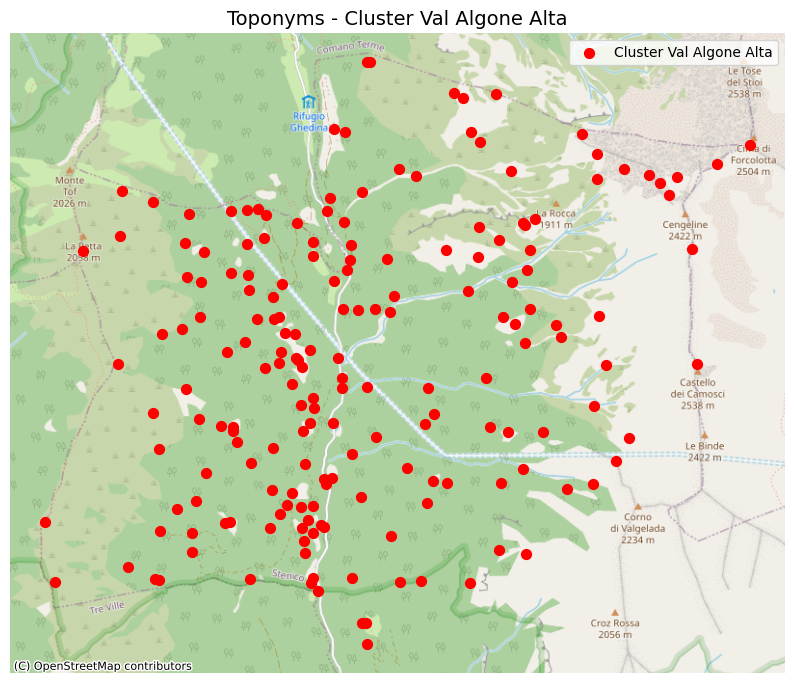

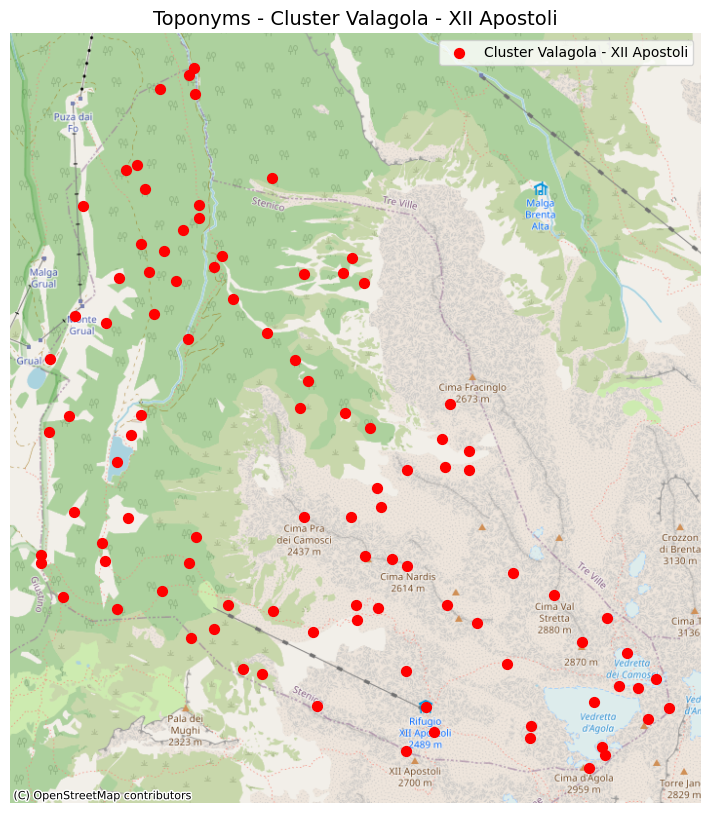

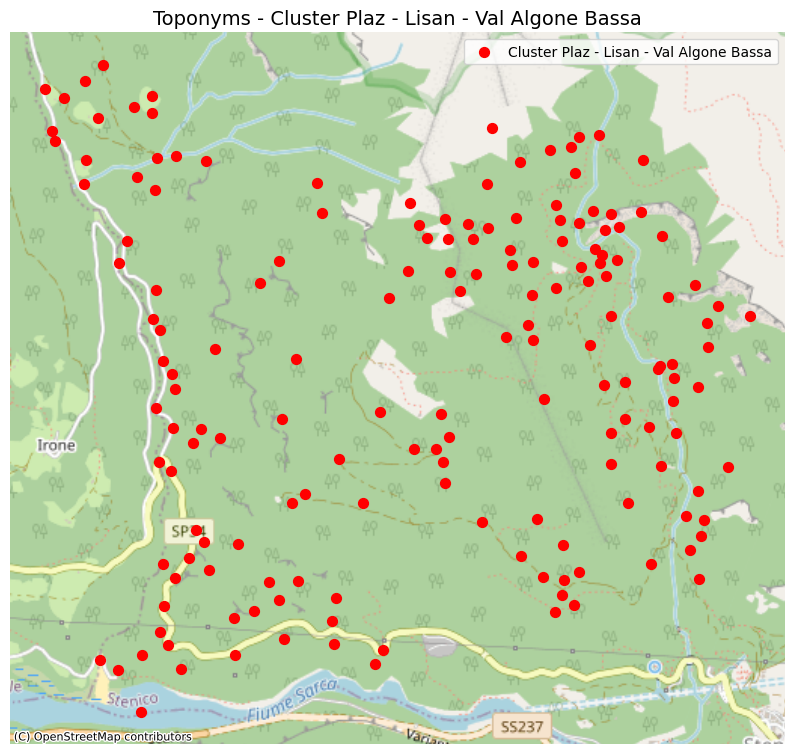

In [53]:
gdf = get_GeoDataFrame(data)

for cluster_id in gdf['hc_cluster'].unique():
    gdf_cluster = gdf[gdf['hc_cluster'] == cluster_id]
    
    fig, ax = plt.subplots(figsize=(10, 10))
    
    gdf_cluster.plot(
        ax=ax,
        color='red',
        markersize=50,
        label=f"Cluster {cluster_id}"
    )
    
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
    ax.set_title(f"Toponyms - Cluster {cluster_id}", fontsize=14)
    ax.set_axis_off()
    plt.legend()
    
    plt.savefig(cluster_maps_path / f"cluster_{cluster_id.replace(' ', '')}.png", dpi=200, bbox_inches='tight', pad_inches=0.1)
    plt.show()

##### Get Nearest Neighbors
For each toponimo I get its 5 closest neighbors.

In [54]:
from scipy.spatial import KDTree

coords = data[['lat', 'lon']].to_numpy()

tree = KDTree(coords)

_, indices = tree.query(coords, k=6)

data['closest_5_neighbors_ids'] = [
    data.iloc[neighbors[1:]]['id'].tolist() for neighbors in indices
]

In [55]:
print(data.loc[100, "nome"])
print("Nearest points:", [data.loc[x, "nome"] for x in data.loc[100, "closest_5_neighbors_ids"]])

Busa de Venédech
Nearest points: ['Baloton de Venédech', 'Cóel de Venédech', 'Dosson de le Pózze', 'Pèzza ùltima', 'Cólm de Venédech']


##### Save to file

In [57]:
save_dir = "../data/toponimi"
os.makedirs(save_dir, exist_ok=True)
save_path = Path(f"{save_dir}/{comune}.json")

data.to_json(save_path, index=False, orient='records')

print("Saved to ", save_path)

Saved to  ../data/toponimi/Stenico.json
